In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
path = Path('../data/smell')

In [5]:
import sys
sys.path.append('../')

from pipeline.features import get_merged_df
from pipeline import models, validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from itertools import combinations

In [3]:
subj = 'A4SHD_21F'
features_path = path / f'{subj}_inhale_features'
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]

class_names = {1: 'Citrus', 2: 'Coffee', 3: 'Vanilla', 4: 'Water'}


In [4]:
def get_binary(data, class_1, class_2=None):
    if class_2 is not None:
        bin_data = data[(data['target'] == class_1) | (data['target'] == class_2)].copy()
    else:
        bin_data = data.copy()

    bin_data.loc[bin_data['target'] != class_1, 'target'] = 0
    bin_data.loc[bin_data['target'] == class_1, 'target'] = 1
    return bin_data.reset_index(drop=True).sample(frac=1)

In [12]:
data = pd.read_csv(features_path/'baseline.csv', index_col='Unnamed: 0')
features = list(data.columns.difference(['fn', 'target']))
ch_names = data.columns.str.split('_', 1, expand=True).get_level_values(0).difference(['target']).to_list()
data.head()

,Fp1_mean,Fp2_mean,F7_mean,F3_mean,Fz_mean,F4_mean,F8_mean,T3_mean,C3_mean,Cz_mean,...,C4_std,T4_std,T5_std,P3_std,Pz_std,P4_std,T6_std,O1_std,O2_std,target
0,5.476820e-11,6.358849e-11,5.244603e-11,7.903467e-11,8.269926e-11,8.732982e-11,5.075845e-11,8.838957e-11,2.189857e-10,3.345850e-10,...,1.059533e-10,3.056155e-11,1.050047e-10,2.642445e-10,4.169818e-10,3.776755e-10,1.584446e-10,1.304534e-10,2.451194e-10,1
1,1.386051e-10,7.884947e-11,5.930822e-11,1.526049e-10,1.422883e-10,1.163825e-10,5.022872e-11,7.701282e-11,3.425515e-10,5.281641e-10,...,2.601669e-10,7.739633e-11,1.147186e-10,4.266124e-10,6.694413e-10,6.427358e-10,1.780139e-10,1.060154e-10,2.546162e-10,1
2,9.183398e-11,7.596609e-11,7.363824e-11,1.610715e-10,1.424902e-10,1.374739e-10,5.895853e-11,7.983833e-11,4.286913e-10,7.335159e-10,...,4.790868e-10,1.504603e-11,1.596047e-10,8.576016e-10,1.301996e-09,1.320175e-09,4.284265e-10,1.740868e-10,5.163595e-10,1
3,7.118582e-11,5.873586e-11,6.522775e-11,1.205407e-10,1.005179e-10,9.249823e-11,6.199296e-11,5.215314e-11,3.075634e-10,4.258486e-10,...,2.052738e-10,3.865663e-11,9.480857e-11,3.567713e-10,5.419661e-10,6.604429e-10,3.701189e-10,1.202206e-10,3.792895e-10,1
4,1.029511e-10,7.151963e-11,6.789690e-11,9.953743e-11,7.795030e-11,6.077812e-11,5.028720e-11,4.709060e-11,2.344107e-10,2.491503e-10,...,1.227144e-10,3.324440e-11,1.661859e-10,4.696095e-10,7.159563e-10,8.509541e-10,5.588410e-10,2.113593e-10,6.909829e-10,1


In [86]:


dfs = []

for i, j in combinations(range(1, 5), 2):
    scores = {}

    for ch in ch_names:
        df = get_binary(data[[f'{ch}_mean', f'{ch}_std', 'target']], i, j)

        train_scores = []
        test_scores = []

        for _ in range(100):
            train_ix, test_ix = train_test_split(df.index, stratify=df['target'])

            X_train, y_train = df.loc[train_ix, [f'{ch}_mean', f'{ch}_std']], df.loc[train_ix, 'target']
            X_test, y_test = df.loc[test_ix, [f'{ch}_mean', f'{ch}_std']], df.loc[test_ix, 'target']

            clf = KNeighborsClassifier().fit(X_train, y_train)

            train_scores.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
            test_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

        scores[ch] = (np.mean(train_scores), np.mean(test_scores))

    dfs.append(pd.DataFrame(scores, index=[f'train {i, j}', f'test {i, j}']).T)

In [87]:
pd.concat(dfs, axis=1).round(3)

,"train (1, 2)","test (1, 2)","train (1, 3)","test (1, 3)","train (1, 4)","test (1, 4)","train (2, 3)","test (2, 3)","train (2, 4)","test (2, 4)","train (3, 4)","test (3, 4)"
C3,0.718,0.472,0.733,0.509,0.676,0.460,0.726,0.562,0.706,0.542,0.733,0.497
C4,0.655,0.373,0.689,0.441,0.687,0.442,0.766,0.603,0.658,0.359,0.799,0.625
Cz,0.611,0.366,0.676,0.397,0.731,0.532,0.641,0.346,0.669,0.452,0.752,0.520
F3,0.700,0.506,0.776,0.527,0.737,0.476,0.695,0.432,0.677,0.427,0.656,0.353
F4,0.679,0.459,0.736,0.498,0.697,0.392,0.752,0.548,0.704,0.438,0.709,0.470
F7,0.716,0.442,0.738,0.442,0.782,0.577,0.698,0.454,0.719,0.513,0.676,0.427
F8,0.683,0.417,0.651,0.406,0.682,0.384,0.679,0.463,0.672,0.474,0.690,0.443
Fp1,0.828,0.685,0.745,0.549,0.729,0.529,0.746,0.553,0.759,0.576,0.712,0.428
Fp2,0.672,0.392,0.683,0.449,0.688,0.432,0.667,0.385,0.665,0.396,0.634,0.374
Fz,0.696,0.454,0.726,0.480,0.684,0.399,0.722,0.510,0.729,0.499,0.761,0.533


## Repeated train/test validation on all features

In [26]:
for i, j in combinations(range(1, 5), 2):
    df = get_binary(data, i, j)

    train_scores = []
    test_scores = []

    for _ in range(200):
        train_ix, test_ix = train_test_split(df.index, stratify=df['target'])

        X_train, y_train = df.loc[train_ix, features], df.loc[train_ix, 'target']
        X_test, y_test = df.loc[test_ix, features], df.loc[test_ix, 'target']

        clf = KNeighborsClassifier().fit(X_train, y_train)

        train_scores.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        test_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    print(f"{np.mean(train_scores):.3f} {np.mean(test_scores):.3f}", end=' ')

0.652 0.392 0.698 0.428 0.747 0.532 0.742 0.500 0.716 0.495 0.795 0.598 

## Select features using the train dataset

In [93]:
model = KNeighborsClassifier()

df = get_binary(data, 1, 3)

train_ix, test_ix = train_test_split(df.index, stratify=df['target'])
selected_features, score, history = models.select_features(df.loc[train_ix], features, model, verbose=True)
print(f"{score.roc_aucs.mean() = }, {score.accs.mean() = }")

X_train, y_train = df.loc[train_ix, selected_features], df.loc[train_ix, 'target']
X_test, y_test = df.loc[test_ix, selected_features], df.loc[test_ix, 'target']

clf = KNeighborsClassifier().fit(X_train, y_train)

print(f"{roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")

Feature selection. Step 1
feature_name    	roc-auc 	accuracy


  0%|          | 0/38 [00:00<?, ?it/s]

O2_mean         	0.384783	0.420000
P4_std          	0.334684	0.383333
T5_std          	0.480138	0.545556
T4_mean         	0.435919	0.480000
F4_mean         	0.380484	0.431111
T3_std          	0.275049	0.308889
Cz_std          	0.474061	0.455556
C3_std          	0.425000	0.511111
T6_std          	0.439872	0.445556
T5_mean         	0.361512	0.436667
F7_mean         	0.471393	0.504444
Cz_mean         	0.524901	0.623333
F8_std          	0.537994	0.635556
F8_mean         	0.545158	0.601111
Fz_mean         	0.509931	0.558889
O2_std          	0.276186	0.324444
Fp1_mean        	0.521097	0.586667
F3_std          	0.488488	0.546667
Pz_std          	0.331374	0.426667
Fp2_std         	0.540119	0.613333
C4_std          	0.447184	0.515556
Fp1_std         	0.528804	0.591111
P4_mean         	0.265563	0.325556
T4_std          	0.498271	0.580000
O1_mean         	0.405237	0.452222
T6_mean         	0.414032	0.452222
F4_std          	0.530781	0.550000
P3_std          	0.386067	0.426667
F3_mean         	0.5

  0%|          | 0/4 [00:00<?, ?it/s]

Cz_mean         	0.486364	0.467778
F8_std          	0.530534	0.611111
F8_mean         	0.540464	0.626667
T3_mean         	0.545158	0.601111

score.roc_aucs.mean() = 0.5582509881422926, score.accs.mean() = 0.6211111111111111
0.4375


In [62]:
history

,feature,action,score,score_std
0,Pz_mean,added,0.590267,0.040625
1,F3_mean,added,0.606719,0.036855
2,Fp2_std,added,0.615761,0.040543
3,T4_mean,added,0.629150,0.041257
4,Fp2_std,removed,0.634387,0.040918


In [97]:
model = KNeighborsClassifier()

In [108]:
feature_selection_results = {}

for i, j in combinations(range(1, 5), 2):
    method = validation.TrainTestValidator(get_binary(data, i, j), features, model, p_bar=0)
    selected_features, score = method.get_features()
    feature_selection_results[i, j] = (selected_features, score.roc_auc)

In [121]:
from collections import defaultdict
from tqdm import trange

nested_cv_scores = defaultdict(list)

for i, j in combinations(range(1, 5), 2):
    for _ in trange(20):
        method = validation.NestedCrossValidator(get_binary(data, i, j), features, model, p_bar=0)
        # selected_features, score = method.get_features()
        score = method.get_prediction_result()
        nested_cv_scores[i, j].append(score.roc_auc)


100%|██████████| 20/20 [09:24<00:00, 28.24s/it]


In [130]:
for (i, j), scores in nested_cv_scores.items():
    print(f"{class_names[i]}/{class_names[j]} {np.mean(scores):.3f}")

Citrus/Coffee 0.537
Citrus/Vanilla 0.508
Citrus/Water 0.566
Coffee/Vanilla 0.403
Coffee/Water 0.449
Vanilla/Water 0.483


<AxesSubplot:ylabel='Density'>

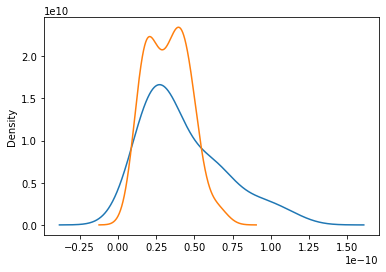

In [13]:
data.loc[data['target'] == 1, 'Fp1_std'].plot.kde()
data.loc[data['target'] == 2, 'Fp1_std'].plot.kde()

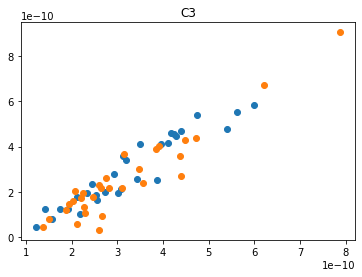

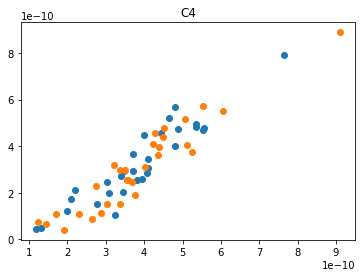

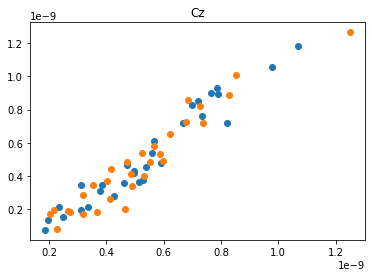

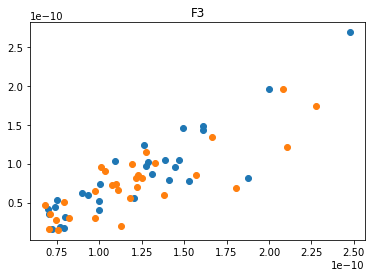

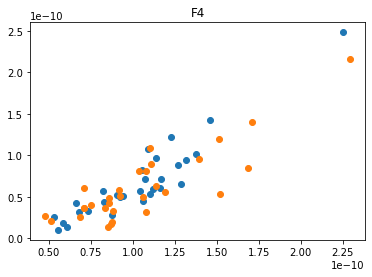

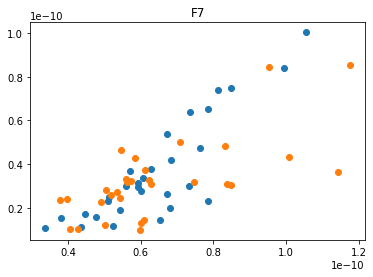

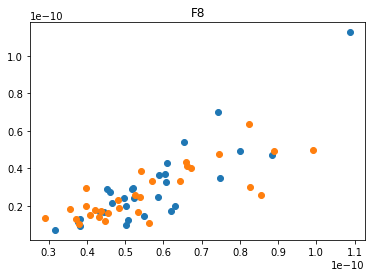

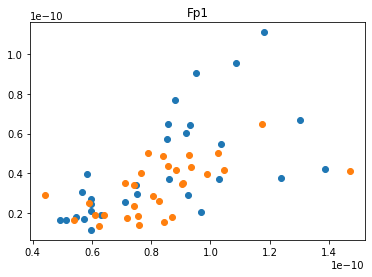

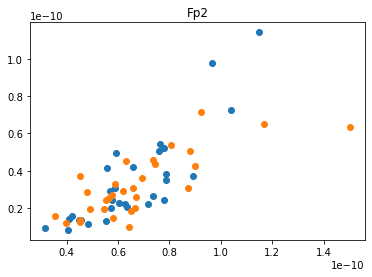

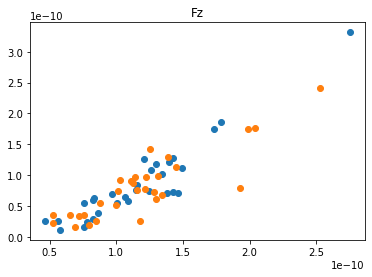

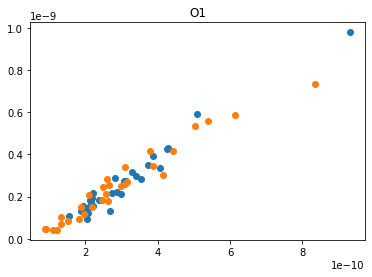

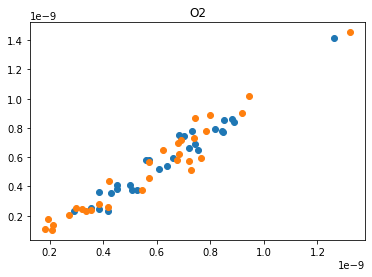

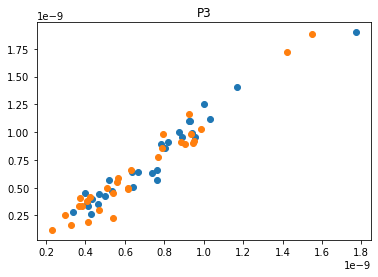

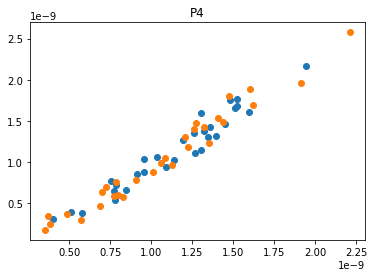

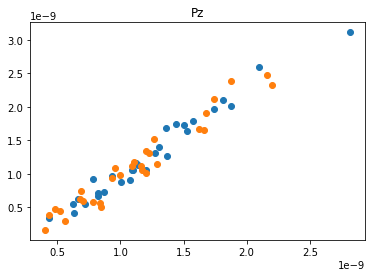

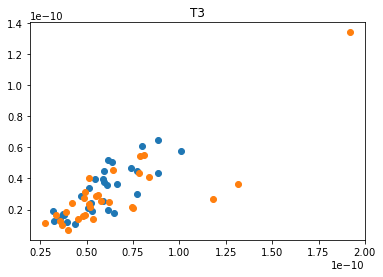

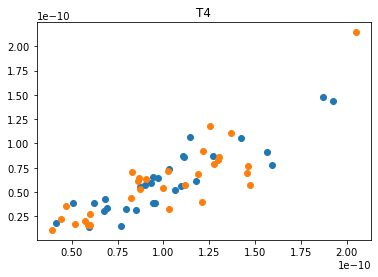

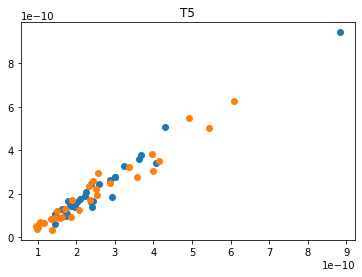

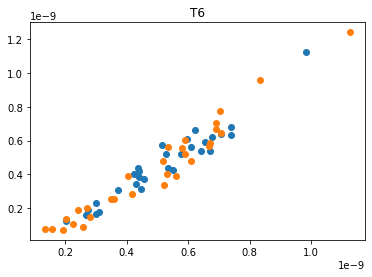

In [23]:
import matplotlib.pyplot as plt
for ch in ch_names:
    plt.title(ch)
    plt.scatter(*data.loc[data['target'] == 1, [f'{ch}_mean', f'{ch}_std']].values.T)
    plt.scatter(*data.loc[data['target'] == 2, [f'{ch}_mean', f'{ch}_std']].values.T)
    plt.show()

In [ ]:
from scipy.stats import pearsonr
for i, j in combinations(range(1, 5), 2):
    for feature in features:
        


In [14]:
from scipy.stats import ttest_ind

dfs = []
for i, j in combinations(range(1, 5), 2):

    t_tests = ttest_ind(data.loc[data['target'] == i, features], data.loc[data['target'] == j, features])
    dfs.append(pd.Series(np.stack(t_tests)[1], index=features, name=f'{class_names[i]}/{class_names[j]}'))

p_vals = pd.concat(dfs, axis=1).round(2)

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [76]:
def accuracy_score(true, prob, thresh=0.5):
    return np.mean(true == (prob >= thresh))

In [78]:
from sklearn.linear_model import LogisticRegression

In [114]:
for (i, j), (test_features, score) in feature_selection_results.items():
    df = get_binary(data, i, j)

    train_scores = []
    test_scores = []

    for _ in range(200):
        train_ix, test_ix = train_test_split(df.index, stratify=df['target'])

        X_train, y_train = df.loc[train_ix, test_features], df.loc[train_ix, 'target']
        X_test, y_test = df.loc[test_ix, test_features], df.loc[test_ix, 'target']

        clf = KNeighborsClassifier().fit(X_train, y_train)

        train_scores.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        test_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    print(f"{class_names[i]}/{class_names[j]}\t{score:.3f} {np.mean(train_scores):.3f} {np.std(train_scores):.3f} {np.mean(test_scores):.3f} {np.std(test_scores):.3f}")

Citrus/Coffee	0.304 0.756 0.047 0.555 0.124
Citrus/Vanilla	0.679 0.765 0.047 0.597 0.130
Citrus/Water	0.616 0.828 0.034 0.706 0.112
Coffee/Vanilla	0.723 0.839 0.037 0.687 0.110
Coffee/Water	0.589 0.848 0.030 0.666 0.126
Vanilla/Water	0.527 0.816 0.042 0.683 0.107


In [116]:
for (i, j), (features, _) in feature_selection_results.items():
    print(f"{class_names[i]}/{class_names[j]}\t", *features)

Citrus/Coffee	 Fp2_mean O1_std Fp1_mean T5_mean O1_mean
Citrus/Vanilla	 O2_mean C4_mean C3_mean F3_mean
Citrus/Water	 O1_mean T4_std
Coffee/Vanilla	 F8_mean F7_std T6_mean Fp1_mean T4_std F3_std F3_mean
Coffee/Water	 Fp1_std
Vanilla/Water	 O2_mean O1_mean C4_std C4_mean F7_std


In [8]:
data = get_merged_df(features_path / 'all_0_0_7', feature_methods)
features = list(data.columns.difference(['fn', 'target']))
data.head()

,env_alpha_fp1_fp2,env_alpha_fp1_f7,env_alpha_fp1_f3,env_alpha_fp1_fz,env_alpha_fp1_f4,env_alpha_fp1_f8,env_alpha_fp1_t3,env_alpha_fp1_c3,env_alpha_fp1_cz,env_alpha_fp1_c4,...,bands_alpha_pz,bands_beta_pz,bands_alpha_p4,bands_beta_p4,bands_alpha_t6,bands_beta_t6,bands_alpha_o1,bands_beta_o1,bands_alpha_o2,bands_beta_o2
0,0.728747,0.557128,0.652252,0.774022,0.630732,0.500448,0.114410,0.270400,0.400406,0.430984,...,0.419438,0.149982,0.375767,0.119748,0.312296,0.204379,0.219560,0.156076,0.290165,0.131872
1,0.191329,0.293626,0.279259,0.340023,0.281449,0.234218,0.075645,0.257257,0.288395,0.234279,...,0.473191,0.105472,0.483560,0.111492,0.288829,0.177723,0.150658,0.115895,0.238478,0.102426
2,0.570483,0.488297,0.456368,0.444780,0.311246,0.212093,0.147013,0.383302,0.348944,0.240513,...,0.514799,0.072773,0.541080,0.067787,0.377990,0.113485,0.287490,0.158040,0.454373,0.113725
3,0.682393,0.383139,0.631745,0.628942,0.544653,0.422603,-0.097839,0.553785,0.445966,0.241486,...,0.469203,0.126967,0.454507,0.112658,0.369901,0.138770,0.266381,0.109961,0.322294,0.099955
4,0.671084,0.543896,0.620903,0.503212,0.300300,0.630495,0.026636,0.348767,0.087897,0.022022,...,0.318246,0.107448,0.371171,0.107085,0.384489,0.116639,0.227058,0.087034,0.326424,0.080596


## KNN

In [18]:
model = KNeighborsClassifier()

selected_features, score, history = models.select_features(df.loc[train_ix], features, model)
f"{score.roc_aucs.mean() = }, {score.accs.mean() = }"

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

'score.roc_aucs.mean() = 0.6342885375494072, score.accs.mean() = 0.6133333333333333'

In [19]:
history

,feature,action,score,score_std
0,Fz_mean,added,0.559190,0.020404
1,F7_mean,added,0.591551,0.023271
2,Pz_std,added,0.609634,0.025820
3,Fp1_std,added,0.619318,0.025898
4,Fz_mean,removed,0.626581,0.027003
5,F7_mean,removed,0.634289,0.025973


In [9]:
X_train, y_train = df.loc[train_ix, selected_features], df.loc[train_ix, 'target']
X_test, y_test = df.loc[test_ix, selected_features], df.loc[test_ix, 'target']

roc_auc_score(y_test, KNeighborsClassifier().fit(X_train, y_train).predict_proba(X_test)[:, 1])

0.4285714285714286

In [138]:
model = models.LRScaled()
feature_selection_results = {}

for i, j in combinations(range(1, 5), 2):
    method = validation.TrainTestValidator(get_binary(data, i, j), features, model, p_bar=0)
    selected_features, score = method.get_features()
    feature_selection_results[i, j] = (selected_features, score.roc_auc)

In [139]:
for (i, j), (test_features, score) in feature_selection_results.items():
    df = get_binary(data, i, j)

    train_scores = []
    test_scores = []

    for _ in range(200):
        train_ix, test_ix = train_test_split(df.index, stratify=df['target'])

        X_train, y_train = df.loc[train_ix, test_features], df.loc[train_ix, 'target']
        X_test, y_test = df.loc[test_ix, test_features], df.loc[test_ix, 'target']

        clf = KNeighborsClassifier().fit(X_train, y_train)

        train_scores.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        test_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    print(f"{class_names[i]}/{class_names[j]}\t{score:.3f} {np.mean(train_scores):.3f} {np.std(train_scores):.3f} {np.mean(test_scores):.3f} {np.std(test_scores):.3f}")

Citrus/Coffee	0.232 0.811 0.046 0.667 0.112
Citrus/Vanilla	0.482 0.862 0.039 0.686 0.117
Citrus/Water	0.393 0.891 0.028 0.776 0.109
Coffee/Vanilla	0.464 0.862 0.038 0.729 0.111
Coffee/Water	0.375 0.894 0.032 0.741 0.114
Vanilla/Water	0.732 0.899 0.032 0.797 0.095


In [141]:
for (i, j), (features, _) in feature_selection_results.items():
    print(f"{class_names[i]}/{class_names[j]}\t", *features)

Citrus/Coffee	 env_beta_fz_t3 bands_beta_fp1 env_alpha_f4_o1 env_alpha_c4_o2 env_alpha_f3_o1 coh_alpha_f3_f8 env_beta_c4_pz coh_beta_f4_p3 bands_alpha_f3 env_alpha_cz_o1 bands_alpha_t3 coh_alpha_fp2_t3 env_alpha_f4_t3 coh_beta_fp1_f4
Citrus/Vanilla	 env_beta_f3_o1 coh_alpha_f4_f8 coh_beta_c4_pz env_alpha_fz_t4 coh_beta_fp1_p4 coh_alpha_fp2_f8 env_alpha_c4_t4 env_alpha_fz_t3 env_beta_fp1_f4 env_alpha_fz_t5 env_beta_fz_f4
Citrus/Water	 env_alpha_fp1_t3 coh_beta_c3_t6 env_beta_fp1_t5 coh_alpha_o1_o2 coh_alpha_t6_o1 env_alpha_c4_o2 env_alpha_f3_f8 env_alpha_c4_o1 env_beta_fz_t3 env_alpha_t3_o2 env_alpha_c3_o1 coh_alpha_c4_t5 env_alpha_c4_p3 env_beta_f4_t3 coh_beta_t5_p3
Coffee/Vanilla	 coh_beta_fp1_f4 env_beta_fz_p4 env_beta_c3_t4 env_alpha_cz_c4 env_alpha_f8_t5 env_alpha_fz_o1 env_alpha_fz_c4 coh_beta_f3_f8 env_beta_f3_p3 coh_alpha_c3_t4 coh_beta_fp2_f7
Coffee/Water	 coh_alpha_fp2_t4 env_alpha_fp1_t3 env_alpha_fz_f4 coh_beta_f8_p4 env_alpha_t3_c4 coh_beta_f8_t5 coh_beta_f7_t4 coh_beta_fp1

In [11]:
model = models.LRScaled()

for i, j in combinations(range(1, 5), 2):
    method = validation.NestedCrossValidator(get_binary(data, i, j), features, model, p_bar=1)
    score = method.get_prediction_result()
    print(f"{class_names[i]}/{class_names[j]}\t{score.roc_auc = }, {score.acc = }")

  0%|          | 0/10 [00:00<?, ?it/s]

Citrus/Coffee	score.roc_auc = 0.6688888888888889, score.acc = 0.6


  0%|          | 0/10 [00:00<?, ?it/s]

Citrus/Vanilla	score.roc_auc = 0.51, score.acc = 0.4166666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

Citrus/Water	score.roc_auc = 0.4722222222222223, score.acc = 0.4166666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

Coffee/Vanilla	score.roc_auc = 0.4444444444444445, score.acc = 0.4


  0%|          | 0/10 [00:00<?, ?it/s]

Coffee/Water	score.roc_auc = 0.46222222222222226, score.acc = 0.4666666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

Vanilla/Water	score.roc_auc = 0.5155555555555555, score.acc = 0.5


## LR

In [39]:
df = get_binary(data, 2, 4)

model = models.LRScaled()

selected_features, score, history = models.select_features(df.loc[train_ix], features, model)
f"{score.roc_aucs.mean() = }, {score.accs.mean() = }"

  0%|          | 0/722 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

'score.roc_aucs.mean() = 0.9993083003952569, score.accs.mean() = 0.9533333333333334'

In [40]:
history

,feature,action,score,score_std
0,coh_alpha_p3_t6,added,0.755237,0.010481
1,coh_alpha_t5_t6,added,0.760474,0.013814
2,coh_beta_c4_t6,added,0.804249,0.012238
3,coh_alpha_p3_o1,added,0.812055,0.015635
4,coh_beta_t4_t6,added,0.862549,0.010615
5,coh_alpha_fp1_fz,added,0.884387,0.011344
6,coh_beta_fz_t3,added,0.895455,0.010381
7,coh_beta_fp2_f7,added,0.917589,0.009123
8,env_beta_t6_o1,added,0.947727,0.010651
9,env_alpha_t3_c3,added,0.961660,0.006886


In [12]:
X_train, y_train = df.loc[train_ix, selected_features], df.loc[train_ix, 'target']
X_test, y_test = df.loc[test_ix, selected_features], df.loc[test_ix, 'target']

roc_auc_score(y_test, models.LRScaled().fit(X_train, y_train).predict_proba(X_test)[:, 1])

0.3571428571428572

In [17]:
method = validation.NestedCrossValidator(get_binary(data, 1, 3), features, model, p_bar=1)
score = method.get_prediction_result()
f"{score.roc_auc = }, {score.acc = }"

NameError: name 'model' is not defined

In [14]:
method = validation.TrainTestValidator(get_binary(data, 1, 3), features, model, p_bar=1)
selected_features, score = method.get_features()
f"{score.roc_auc = }, {score.acc = }"

  0%|          | 0/722 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

'score.roc_auc = 0.25, score.acc = 0.3333333333333333'